In [1]:
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional

import datasets
import numpy as np
from datasets import load_dataset, load_metric

# Torch modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Lightning modules
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchmetrics.classification import MulticlassAUROC
from torchmetrics import F1Score
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import transformers
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version
from transformers.utils.versions import require_version

import plotly.express as px

tqdm.pandas()

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading in dataset

In [2]:
df_ACL_2020 = pd.read_csv("./Data/ACL_2022.csv")
df_EMNLP_2020 = pd.read_csv("./Data/EMNLP_2020.csv")
df_base = pd.read_parquet("./Data/acl-publication-info.74k.parquet")

In [3]:
df_base = df_base[['title', 'author', "abstract", "full_text"]]

In [4]:
df_base['title'] = df_base['title'].str.replace('{','')
df_base['title'] = df_base['title'].str.replace('}','')

C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_34044\783417164.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_base['title'] = df_base['title'].str.replace('{','')
C:\Users\Benjamin Aw\AppData\Local\Temp\ipykernel_34044\783417164.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_base['title'] = df_base['title'].str.replace('}','')


In [5]:
#45 rows dropped because entries are mismatched or cannot be found in original dataset
df_ACL_2020 = df_ACL_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [6]:
#65 rows dropped because entries are mismatched or cannot be found in original dataset
df_EMNLP_2020 = df_EMNLP_2020.merge(df_base, how ='left', left_on = 'Paper Name', right_on = 'title').dropna(subset=['title'])

In [7]:
df_ACL_2020 = df_ACL_2020[(df_ACL_2020['Labels'] != 'Theme') & (df_ACL_2020['Labels'] != 'System Demonstrations') & (df_ACL_2020['Labels'] != 'Student Research Workshop')]

In [8]:
df_EMNLP_2020 = df_EMNLP_2020[(df_EMNLP_2020['Labels'] != 'Theme') & (df_EMNLP_2020['Labels'] != 'System Demonstrations') & (df_EMNLP_2020['Labels'] != 'Student Research Workshop')]

In [9]:
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_ACL_2020 = df_ACL_2020[df_ACL_2020['abstract'].str.len() != 0]
#3 rows dropped because of empty abstract, we can get around this later by taking a portion of the full text
df_EMNLP_2020 = df_EMNLP_2020[df_EMNLP_2020['abstract'].str.len() != 0]

In [10]:
df_ACL_2020 = df_ACL_2020[['Labels', 'Paper Name', 'abstract']]
df_EMNLP_2020 = df_EMNLP_2020[['Labels', 'Paper Name', 'abstract']]

In [11]:
df_EMNLP_2020['abstract'] = df_EMNLP_2020.abstract.str.replace('</s>', '', regex=False)

In [12]:
df_ACL_2020['hypothesis'] = "This paper is about " + df_ACL_2020['Labels']
df_ACL_2020['label'] = 0
df_ACL_entail = df_ACL_2020[["abstract", "hypothesis", "label"]]
df_ACL_entail.columns = ["premise", "hypothesis", "label"]

In [13]:
df_EMNLP_2020['hypothesis'] = "This paper is about " + df_EMNLP_2020['Labels']
df_EMNLP_2020['label'] = 0
df_EMNLP_entail = df_EMNLP_2020[["abstract", "hypothesis", "label"]]
df_EMNLP_entail.columns = ["premise", "hypothesis", "label"]

In [14]:
possible_hypothesis = df_ACL_entail.hypothesis.unique()

In [15]:
df_ACL_entail = df_ACL_entail.reset_index(drop = True)
df_EMNLP_entail = df_EMNLP_entail.reset_index(drop = True)

In [16]:
df_ACL_entail.columns = ['premise', 'original hypothesis', 'label']
temp_df = pd.DataFrame({'hypothesis': possible_hypothesis})

df_ACL_entail = pd.merge(df_ACL_entail, temp_df, how='cross')

In [17]:
df_ACL_entail['label'] = df_ACL_entail['original hypothesis'] == df_ACL_entail['hypothesis']
df_ACL_entail['label'] = df_ACL_entail['label'].replace({True: 0, False: 1})

In [18]:
df_ACL_entail = df_ACL_entail.reset_index(drop = True)
df_EMNLP_entail = df_EMNLP_entail.reset_index(drop = True)

In [19]:
df_ACL_entail_label_0 = df_ACL_entail[df_ACL_entail["label"] == 0]

### Looking at pretraining a zero shot classifer on ACL dataset (bart-large-mnli)

In [20]:
MODEL_NAME = "facebook/bart-large-mnli"
tokenizer = BartTokenizer.from_pretrained(MODEL_NAME)
N_EPOCHS = 5
BATCH_SIZE = 16
MAX_TOKEN_COUNT = 1024

train_df = df_ACL_entail

class NLPDataset(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int = MAX_TOKEN_COUNT):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        text_premise = data_row["premise"]
        text_hypothesis = data_row["hypothesis"]
        labels = data_row["label"]

        encoding = self.tokenizer.encode_plus(
          text = text_premise,
          text_pair = text_hypothesis,
          add_special_tokens=True,
          max_length=self.max_token_len,
          return_token_type_ids=False,
          padding="max_length",
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return dict(
          text_premise=text_premise,
          text_hypothesis = text_hypothesis,
          input_ids=encoding["input_ids"].flatten(),
          attention_mask=encoding["attention_mask"].flatten(),
          labels=labels
        )
    

class NLPDataModule(pl.LightningDataModule):
    
    def __init__(self, train_df, val_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=MAX_TOKEN_COUNT):
    
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = NLPDataset(
          self.train_df,
          self.tokenizer,
          self.max_token_len
        )
        self.val_dataset = NLPDataset(
          self.val_df,
          self.tokenizer,
          self.max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True
        )
    
    def val_dataloader(self):
        return DataLoader(
          self.val_dataset,
          batch_size=self.batch_size
        )
    
class NLPClassModel(pl.LightningModule):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
        super().__init__()
        self.bartmnli = BartForSequenceClassification.from_pretrained(MODEL_NAME, return_dict=True, num_labels = n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.CrossEntropyLoss()
    
        for param in self.bartmnli.model.parameters():
            param.requires_grad = False
    
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bartmnli(input_ids, attention_mask=attention_mask).logits
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    
    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
    
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        metric = MulticlassAUROC(num_classes=3, average="macro", thresholds=None)
        class_roc_auc = metric(predictions, labels)

        self.logger.experiment.add_scalar(f"roc_auc/Train", class_roc_auc, self.current_epoch)
        
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
          optimizer,
          num_warmup_steps=self.n_warmup_steps,
          num_training_steps=self.n_training_steps
        )
        
        return dict(
          optimizer = optimizer,
          lr_scheduler = dict(
            scheduler = scheduler,
            interval = 'step'
          )
        )

### For loop starts here

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:604: UserWarning: Checkpoint directory C:\Users\Benjamin Aw\Desktop\Extract Scientific Papers\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name      | Type                          | Params
------------------------------------------------------------
0 | bartmnli  | BartForSequenceClassificatio

Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  96%|███████████████████████████▊ | 1081/1126 [21:45<00:54,  1.21s/it, loss=0.156, v_num=36, train_loss=0.404]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████| 1126/1126 [22:38<00:00,  1.21s/it, loss=0.156, v_num=36, train_loss=0.404, val_loss=2.280]

C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
Epoch 0, global step 1081: 'val_loss' reached 2.27721 (best 2.27721), saving model to 'C:\\Users\\Benjamin Aw\\Desktop\\Extract Scientific Papers\\checkpoints\\best-checkpoint-v33.ckpt' as top 1


Epoch 1:  96%|███████████▌| 1081/1126 [21:46<00:54,  1.21s/it, loss=0.0807, v_num=36, train_loss=0.163, val_loss=2.280]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████| 1126/1126 [22:39<00:00,  1.21s/it, loss=0.0807, v_num=36, train_loss=0.163, val_loss=2.470]

Epoch 1, global step 2162: 'val_loss' was not in top 1


Epoch 2:  96%|███████████▌| 1081/1126 [21:46<00:54,  1.21s/it, loss=0.209, v_num=36, train_loss=0.0359, val_loss=2.470]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████| 1126/1126 [22:39<00:00,  1.21s/it, loss=0.209, v_num=36, train_loss=0.0359, val_loss=1.920]

Epoch 2, global step 3243: 'val_loss' reached 1.92287 (best 1.92287), saving model to 'C:\\Users\\Benjamin Aw\\Desktop\\Extract Scientific Papers\\checkpoints\\best-checkpoint-v33.ckpt' as top 1


Epoch 3:  96%|████████████▍| 1081/1126 [21:39<00:54,  1.20s/it, loss=0.138, v_num=36, train_loss=0.108, val_loss=1.920]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████| 1126/1126 [22:31<00:00,  1.20s/it, loss=0.138, v_num=36, train_loss=0.108, val_loss=2.010]

Epoch 3, global step 4324: 'val_loss' was not in top 1


Epoch 4:  96%|████████████▍| 1081/1126 [21:22<00:53,  1.19s/it, loss=0.163, v_num=36, train_loss=0.407, val_loss=2.010]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████| 1126/1126 [22:15<00:00,  1.19s/it, loss=0.163, v_num=36, train_loss=0.407, val_loss=2.060]

Epoch 4, global step 5405: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█████████████| 1126/1126 [22:15<00:00,  1.19s/it, loss=0.163, v_num=36, train_loss=0.407, val_loss=2.060]


100%|████████████████████████████████████████████████████████████████████████████| 16399/16399 [22:59<00:00, 11.89it/s]


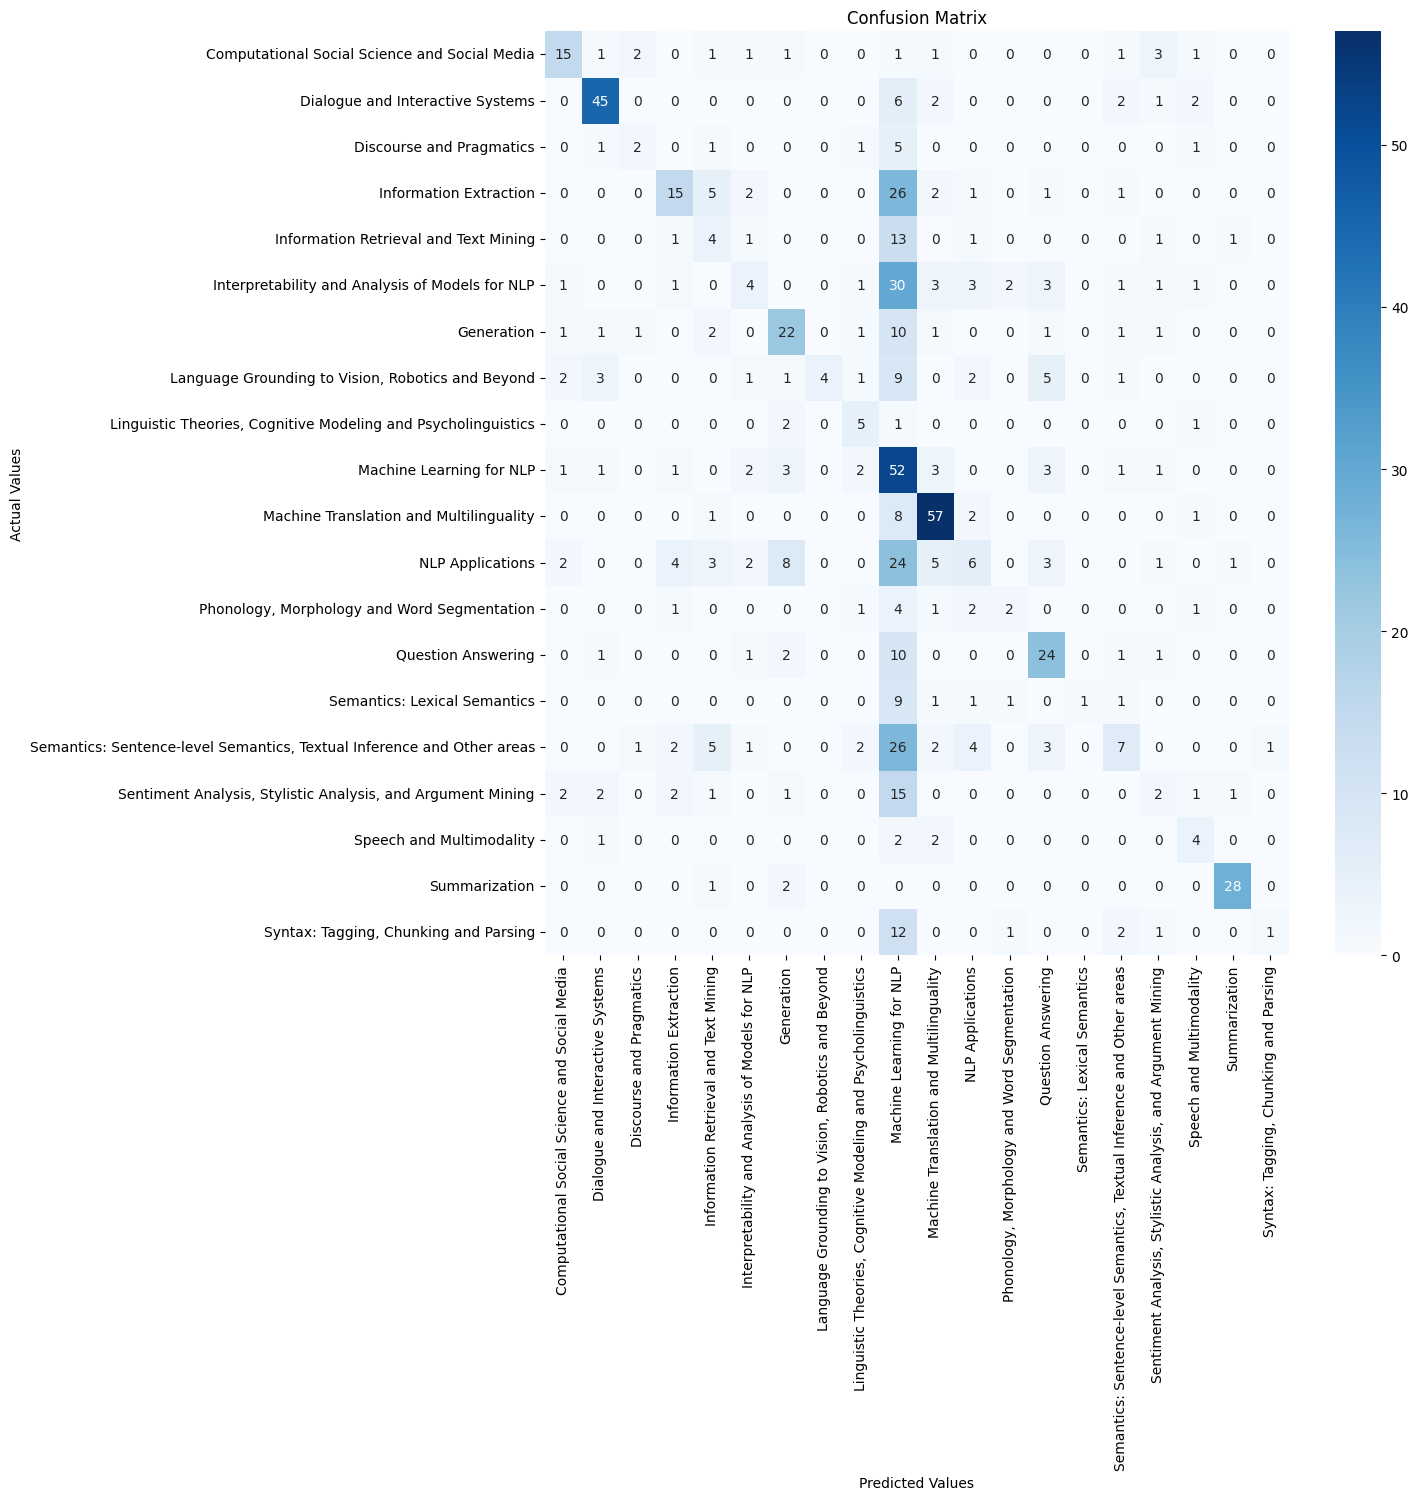

Plot Saved
Classification report Saved
Saved EMNLP Results


C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Benjamin Aw\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [21]:
# Determine what is number of negative hypothesis for 1 each positive hypothesis
negative_examples_list = [16]

for no_examples in negative_examples_list:
    
    val_df = df_EMNLP_entail
    
    negative_examples = no_examples

    df_ACL_entail_label_1 = df_ACL_entail[df_ACL_entail["label"] == 1]
    df_ACL_entail_label_1 = df_ACL_entail_label_1.groupby("premise").sample(n = negative_examples, random_state=2, replace = True)
    df_ACL_entail_label_1 = df_ACL_entail_label_1.drop_duplicates()

    df_ACL_entail = pd.concat([df_ACL_entail_label_0, df_ACL_entail_label_1])

    data_module = NLPDataModule(
      train_df,
      val_df,
      tokenizer,
      batch_size=BATCH_SIZE,
      max_token_len=MAX_TOKEN_COUNT
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath = "checkpoints",
        filename = "best-checkpoint",
        save_top_k = 1,
        verbose = True,
        monitor = "val_loss",
        mode = "min"
    )

    logger = TensorBoardLogger("lightning_logs", name="nlpBART")

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

    trainer = pl.Trainer(
        logger = logger,
        callbacks = [checkpoint_callback, early_stopping_callback],
        max_epochs = N_EPOCHS,
        accelerator = "auto"
    )

    steps_per_epoch=len(train_df) // BATCH_SIZE
    total_training_steps = steps_per_epoch * N_EPOCHS
    warmup_steps = total_training_steps // 5

    model = NLPClassModel(
      n_classes = 3,
      n_warmup_steps = warmup_steps,
      n_training_steps = total_training_steps
    )

    trainer.fit(model, data_module)

    trained_model = NLPClassModel.load_from_checkpoint(
      trainer.checkpoint_callback.best_model_path,
      n_classes = 3
    )

    trained_model.eval()
    trained_model.freeze()

    # Creating a validation set that test across all possible hypothesis
    val_df = val_df.iloc[:, [0,1,2]]
    val_df.columns = ['premise', 'original hypothesis', 'label']
    temp_df = pd.DataFrame({'hypothesis': possible_hypothesis})

    val_df = pd.merge(val_df, temp_df, how='cross')
    val_df['label'] = val_df['original hypothesis'] == val_df['hypothesis']
    val_df['label'] = val_df['label'].replace({True: 0, False: 1})


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model = trained_model.to(device)

    test_dataset = NLPDataset(
        val_df,
        tokenizer,
        max_token_len=MAX_TOKEN_COUNT
    )

    predictions = []
    labels = []

    for item in tqdm(test_dataset):

        _, prediction = trained_model(
            item["input_ids"].unsqueeze(dim=0).to(device),
            item["attention_mask"].unsqueeze(dim=0).to(device)
        )

        predictions.append(prediction.flatten())
        labels.append(item["labels"])

    predictions = torch.stack(predictions).detach().cpu()
    labels = torch.IntTensor(labels).detach().cpu()

    val_df["Score"] = predictions[:, 0]
    scored_val_df = val_df.sort_values('Score').drop_duplicates(['premise', 'original hypothesis'], keep='last')

    scored_val_df = scored_val_df[['premise', 'hypothesis']]

    scored_val_df.columns = ['abstract', 'Max Label']
    
    df_EMNLP_2020 = df_EMNLP_2020[["Labels", "Paper Name", "abstract", "hypothesis", "label"]]
    df_EMNLP_2020 = df_EMNLP_2020.merge(scored_val_df, how="left", on=["abstract"])

    df_EMNLP_2020['hypothesis'] = df_EMNLP_2020['hypothesis'].str.replace('This paper is about ', '', regex=False)
    df_EMNLP_2020['Max Label'] = df_EMNLP_2020['Max Label'].str.replace('This paper is about ', '', regex=False)

    # Plotting of figures

    idx_labels = list(df_EMNLP_2020["Labels"].unique())

    cm = confusion_matrix(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label'], labels = idx_labels)
    cm_df = pd.DataFrame(cm,
                         index = idx_labels, 
                         columns = idx_labels)

    #Plotting the confusion matrix
    plt.figure(figsize=(12,12))
    sns.heatmap(cm_df, annot=True, cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    plt.savefig(f'./Outputs/Confusion_Matrix_{negative_examples}.png')
    print("Plot Saved")

    #Saving classification report
    report = classification_report(df_EMNLP_2020['Labels'], df_EMNLP_2020['Max Label'], output_dict = True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f'./Outputs/Classification_report_{negative_examples}.csv')
    print("Classification report Saved")
    
    #Saving resutls
    df_EMNLP_2020.to_csv(f'./Outputs/EMNLP_results_{negative_examples}.csv')
    print("Saved EMNLP Results")
    
    #Clasification results
#     df_EMNLP_2020["Label outcome"] = df_EMNLP_2020.apply(lambda x: x["Labels"] == x["Max Label"], axis = 1)
#     df_EMNLP_2020_outcome = df_EMNLP_2020[['Labels', 'Label outcome']].groupby(['Labels', 'Label outcome']).size().reset_index(name='Counts')
#     df_EMNLP_2020_outcome = df_EMNLP_2020_outcome.sort_values(by = ['Labels','Label outcome'], ascending = [True, False])
    
#     fig = px.bar(df_EMNLP_2020_outcome, x="Labels", y="Counts", color="Label outcome", title="Predictions for EMNLP Dataset",
#                  width=1800, height=1200)
#     fig.write_image(f'./Outputs/Classification_barchart_{negative_examples}.png')
#     print("Accuracy plot results saved Saved")

#     df_EMNLP_2020_accuracy = df_EMNLP_2020_outcome.pivot(index="Labels", columns="Label outcome", values="Counts").reset_index().fillna(0)
#     df_EMNLP_2020_accuracy["Accuracy"] = df_EMNLP_2020_accuracy[True] / (df_EMNLP_2020_accuracy[False] + df_EMNLP_2020_accuracy[True]) * 100
#     df_EMNLP_2020_accuracy = df_EMNLP_2020_accuracy.sort_values(by = 'Accuracy', axis=0, ascending=False)
#     df_EMNLP_2020_accuracy.to_csv(f'./Outputs/Classification_accuracy_by_topics_{negative_examples}.csv')
#     print("Classification accuracy results saved Saved")